# Validate method for on single location

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload
from scipy import interpolate
import sys
from scipy import signal
import obspy

import airglow_response as ar

25600
17161


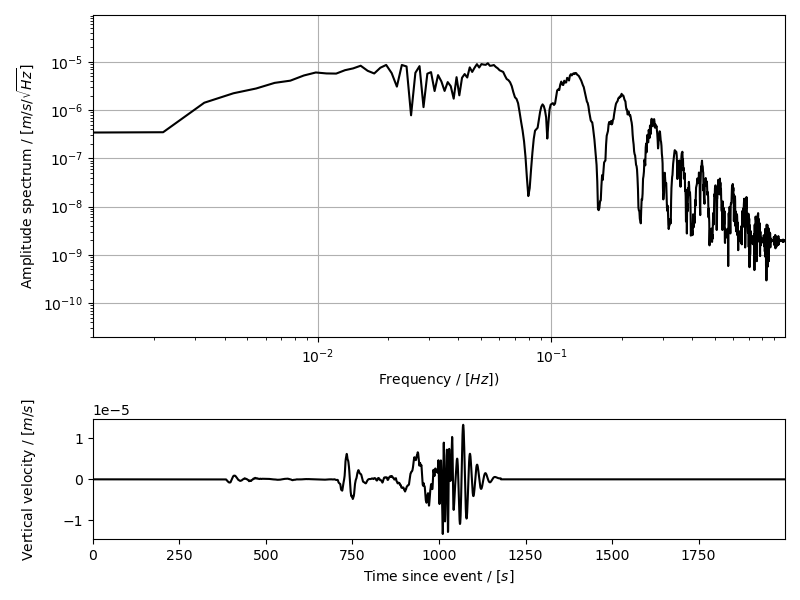

In [2]:
reload(ar)
### Create a synthetic at one single location 
ns, es = 2000e3, 2000e3
depths = 15.e3 
north_shifts = np.array([ns, ns/2, ns/3])
east_shifts = np.array([es, es/2, ns/3])

### Dense grid: 
delta_dist = 50e3
min_dist = 500e3
max_dist = 4000e3
north_shifts = np.arange(-max_dist, max_dist, delta_dist)/np.sqrt(2)
east_shifts = np.arange(-max_dist, max_dist, delta_dist)/np.sqrt(2)
###
#north_shifts = north_shifts[np.where(abs(north_shifts)>=500e3)]
#east_shifts = east_shifts[np.where(abs(east_shifts)>=500e3)]
print(east_shifts.size * north_shifts.size)

gridded = True

opt_synthetics = dict(
    mw = 6.5,
    depth = depths,
    strike = 0., 
    dip = 45., 
    rake = 45.,
    min_dist = min_dist,
    store_id = 'GF_venus_Cold100_qssp',
    #store_id = 'GF_venus_Cold100_qssp_grid',
    north_shifts = north_shifts, 
    east_shifts = east_shifts,
    base_folder='/projects/restricted/infrasound/data/infrasound/2023_Venus_inversion/',
    #stf_type = None,
    stf_type = 'triangle', 
    #stf_type = 'sinus', 
    effective_duration = 25.,
    gridded=gridded
)

### INITIALIZE SEISMOGRAM CLASS 
SEISMO = ar.Seismograms(**opt_synthetics)
print(len(SEISMO.synthetic_traces_u))

fig = SEISMO.plot_traces(ns, es)

In [3]:
reload(ar)
fig = SEISMO.arrange_interpolate_synthetics()

In [10]:
### Load airglow class 
reload(ar)
AIRGLOW = ar.AirglowSignal(SEISMO)

In [11]:
reload(ar)

### Define the locations we are interested in: 
list_inorth= [0,1]
### If the result is not gridded, only give list_inorth
if not gridded:
    list_ieast = [0 for j in range(len(list_inorth))]
### Else, meshgrid 
else: 
    #list_inorth, list_ieast = np.meshgrid(list_inorth, list_inorth)
    # list_inorth = list_inorth.ravel()
    # list_ieast  = list_ieast.ravel()
    ### To get all the grid: 
    list_inorth, list_ieast = AIRGLOW.iNN, AIRGLOW.iEE

### Calculate the 1.27 micrometer airglow 
#AIRGLOW.calculate_1_27_airglow(list_ieast, list_inorth)
AIRGLOW.calculate_1_27_airglow(AIRGLOW.iEE, AIRGLOW.iNN, loc_save = [(0,0)])

100%|████████████████████████████████████████████████████████████████████████████████| 25600/25600 [00:25<00:00, 986.14it/s]


0 7


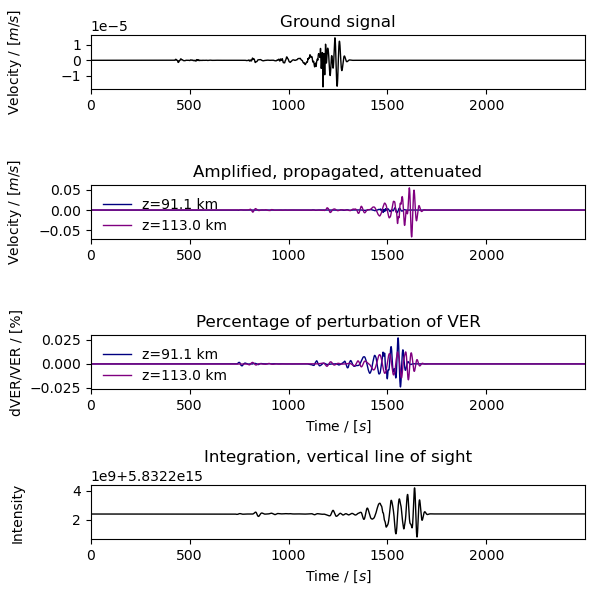

In [12]:
reload(ar)
i_east, i_north = 0, 0
AIRGLOW.plot_nightglow_traces(i_east, i_north)

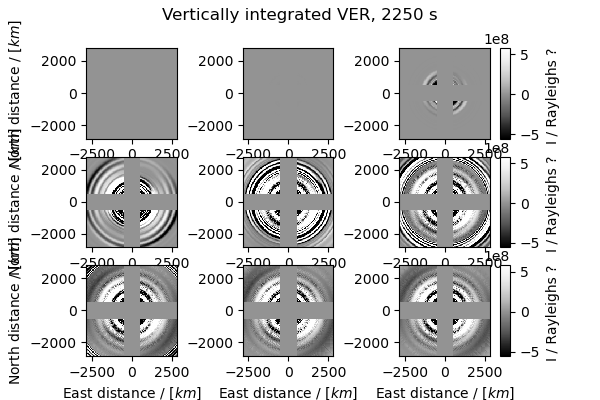

In [13]:
reload(ar)
AIRGLOW. plot_nightglow_images()